# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#load packages 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
df = pd.read_csv('zillow_data.csv')

In [2]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.drop('RegionID', axis=1, inplace=True)

In [4]:
df.drop('SizeRank', axis=1, inplace=True)

In [5]:
df.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 270 entries, RegionName to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 30.3+ MB


# Step 2: Reshape from Wide to Long Format & Data preprocessing

In [7]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [8]:
#Looking at every state & county
#all the zip codes (no state or county info)
zip_dict = {}
#all the states
states_dict = {}

#iterate over all states in 'df'
for s in df.State.unique():
    df_state = df[df.State == s]
    county_dict = {}
    
    #iterate over all state's counties
    for c in df_state.CountyName.unique():
        #choose a specific county within the state
        df_state_county = df_state[df_state.CountyName == c]
        
        #create a dictionary that will have a time series for each counties' zip
        temp_dict_zip = {}
        
        #iterate over all the zip codes within that one county 
        for z in df_state_county.RegionName.unique():
            #choosing that specific zip code
            temp_zip_df = df_state_county[df_state_county.RegionName == z]
            #creating a time series (via melting) for that zip code 
            temp_zip_ts = melt_data(temp_zip_df)
            #this will include all the zip codes in 'df'
            zip_dict[z] = temp_zip_ts
            #adding that time series to a dictionary
            #this will only include time series from zip codes in the county
            temp_dict_zip[z] = temp_zip_ts
            
        #after iterating over all the zip codes in the county, save the dict of zip code time series as a value
        county_dict[c] = temp_dict_zip
        
    #after iterating over all the counties in the state, save the dict of counties
    states_dict[s] = county_dict

In [9]:
#to access data
states_dict['NY']['New York']

{10011:                  value
 time                  
 2005-01-01   3762100.0
 2005-02-01   3908800.0
 2005-03-01   4023200.0
 2005-04-01   4084800.0
 2005-05-01   4080800.0
 2005-06-01   4037400.0
 2005-07-01   4002300.0
 2005-08-01   4005300.0
 2005-09-01   4045100.0
 2005-10-01   4107700.0
 2005-11-01   4191200.0
 2005-12-01   4303900.0
 2006-01-01   4436300.0
 2006-02-01   4557300.0
 2006-03-01   4640100.0
 2006-04-01   4661400.0
 2006-05-01   4611100.0
 2006-06-01   4513000.0
 2006-07-01   4400600.0
 2006-08-01   4302700.0
 2006-09-01   4249100.0
 2006-10-01   4264800.0
 2006-11-01   4353300.0
 2006-12-01   4493200.0
 2007-01-01   4635000.0
 2007-02-01   4741700.0
 2007-03-01   4826000.0
 2007-04-01   4898000.0
 2007-05-01   4938400.0
 2007-06-01   4960300.0
 ...                ...
 2015-11-01  11255300.0
 2015-12-01  11248600.0
 2016-01-01  11286600.0
 2016-02-01  11395300.0
 2016-03-01  11498100.0
 2016-04-01  11574100.0
 2016-05-01  11618900.0
 2016-06-01  11681200.0
 2016-07-

In [10]:
#access just by zipcode
zip_dict[10021]

,value
time,
2004-01-01,13922800.0
2004-02-01,13140500.0
2004-03-01,12333800.0
2004-04-01,11490700.0
2004-05-01,10641200.0
2004-06-01,9840100.0
2004-07-01,9192000.0
2004-08-01,8775700.0
2004-09-01,8601100.0


In [11]:
# We're only considering New York here
df_ny = df[df.State == 'NY']

# Dictionary to include all zip code time series in CA (no county reference)
zip_dict_ny = {}

# Dictionary of dictionaries
county_dict_ny = {}

#aggregated dictionary of counties
county_dict_aggregated = {}

# Itreate over all New York counties
for c in df_ny.CountyName.unique():
    # Choose a specific county (wihtin New York)
    df_ny_county = df_ny[df_ny.CountyName == c]
    # Note we could keep all the aggregated info for a county w/ 1 time series
    county_dict_aggregated[c] = melt_data(df_ny_county)
    
    # Create a dictionary that will have time series for each counties' zip
    # Looks something like this:
    # {
    #   '94509': time_series_0,
    #   '94531': time_series_1,
    #    ... 
    # }
    temp_dict_zip = {}
    
    # Now iterate over all the zip codes within that one county
    for z in df_ny_county.RegionName.unique():
        # Choosing that specific zip code
        temp_zip_df = df_ny_county[df_ny_county.RegionName == z]
        
        # Creating a time series (via melting) for that zip code
        temp_zip_ts = melt_data(temp_zip_df)
        
        # This will eventually include all the zip codes in the state
        zip_dict_ny[z] = temp_zip_ts
        
        # Adding that time series to a dictionary 
        # (This will only include time series from zip codes in the county)
        temp_dict_zip[z] = temp_zip_ts
        
    # After iterating over all the zip codes in the county, save the dict of
    # zip code time series as a value 
    county_dict_ny[c] = temp_dict_zip

In [12]:
county_dict_aggregated['New York']

,value
time,
1996-04-01,1.920650e+06
1996-05-01,1.934750e+06
1996-06-01,1.947750e+06
1996-07-01,1.960650e+06
1996-08-01,1.974600e+06
1996-09-01,1.990900e+06
1996-10-01,2.009400e+06
1996-11-01,2.029600e+06
1996-12-01,2.050250e+06


In [13]:
county_dict_ny['New York']

{10011:                  value
 time                  
 2005-01-01   3762100.0
 2005-02-01   3908800.0
 2005-03-01   4023200.0
 2005-04-01   4084800.0
 2005-05-01   4080800.0
 2005-06-01   4037400.0
 2005-07-01   4002300.0
 2005-08-01   4005300.0
 2005-09-01   4045100.0
 2005-10-01   4107700.0
 2005-11-01   4191200.0
 2005-12-01   4303900.0
 2006-01-01   4436300.0
 2006-02-01   4557300.0
 2006-03-01   4640100.0
 2006-04-01   4661400.0
 2006-05-01   4611100.0
 2006-06-01   4513000.0
 2006-07-01   4400600.0
 2006-08-01   4302700.0
 2006-09-01   4249100.0
 2006-10-01   4264800.0
 2006-11-01   4353300.0
 2006-12-01   4493200.0
 2007-01-01   4635000.0
 2007-02-01   4741700.0
 2007-03-01   4826000.0
 2007-04-01   4898000.0
 2007-05-01   4938400.0
 2007-06-01   4960300.0
 ...                ...
 2015-11-01  11255300.0
 2015-12-01  11248600.0
 2016-01-01  11286600.0
 2016-02-01  11395300.0
 2016-03-01  11498100.0
 2016-04-01  11574100.0
 2016-05-01  11618900.0
 2016-06-01  11681200.0
 2016-07-

#try making a dictionary to keep track of the 114 data frames representing all the NYC zipcodes:
zipcode_dict = {}
for zipcode in df_NYC.RegionName.unique():
    temp_df = df_NYC[df_NYC.RegionName == zipcode]
    zipcode_dict[zipcode] = melt_data(temp_df)

In [14]:
#compare the 5 boroughs/counties of NYC to start
manhattan = county_dict_aggregated['New York']
brooklyn = county_dict_aggregated['Kings']
queens = county_dict_aggregated['Queens']
bronx = county_dict_aggregated['Bronx']
staten = county_dict_aggregated['Richmond']

In [15]:
nyc_list = [manhattan, brooklyn, queens, bronx, staten]

In [16]:
for i in nyc_list:
    i['percent'] = i.pct_change()*100

In [17]:
manhattan

,value,percent
time,,
1996-04-01,1.920650e+06,NaN
1996-05-01,1.934750e+06,0.734126
1996-06-01,1.947750e+06,0.671921
1996-07-01,1.960650e+06,0.662303
1996-08-01,1.974600e+06,0.711499
1996-09-01,1.990900e+06,0.825484
1996-10-01,2.009400e+06,0.929228
1996-11-01,2.029600e+06,1.005275
1996-12-01,2.050250e+06,1.017442


# Step 3: EDA and Visualization

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

### What are our investors looking for?
The best absolute return - not concerned with volatility/variance in monthly/yearly returns because they plan on holding for 10 years +
### Time frame of modeling
Since 1996 where data is applicable. Some of the data only goes back to 2004. Minimum of 15 year back-testing. 

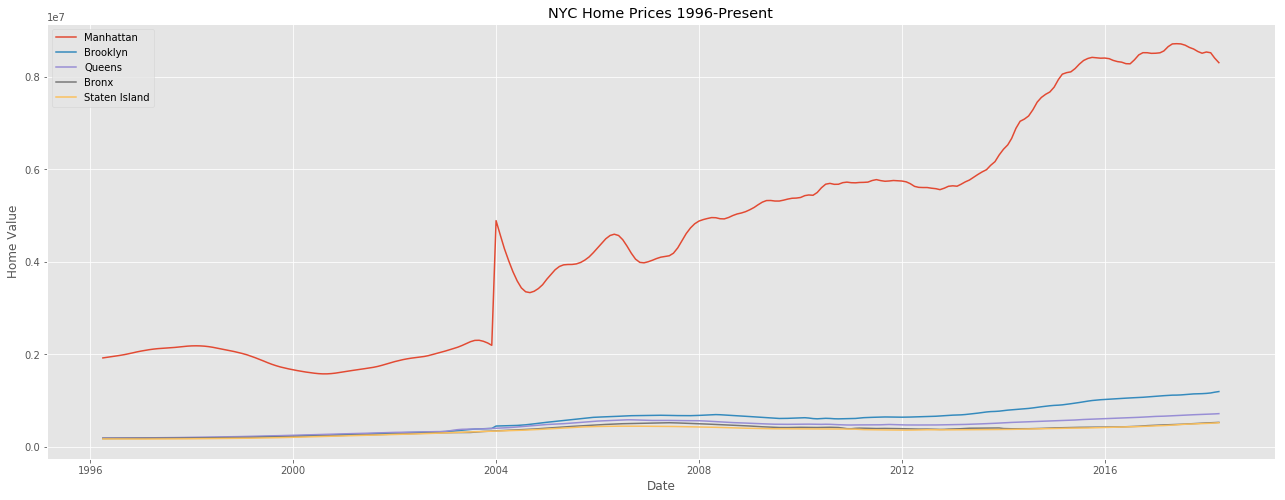

In [96]:
plt.subplots(figsize=(22,8))

plt.plot(manhattan.index, manhattan.value)
plt.plot(brooklyn.index, brooklyn.value)
plt.plot(queens.index, queens.value)
plt.plot(bronx.index, bronx.value)
plt.plot(staten.index, staten.value)


#plt.figure(figsize=(22,15))
plt.legend(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])
plt.ylabel('Home Value')
plt.xlabel('Date')
plt.title('NYC Home Prices 1996-Present')
plt.show()

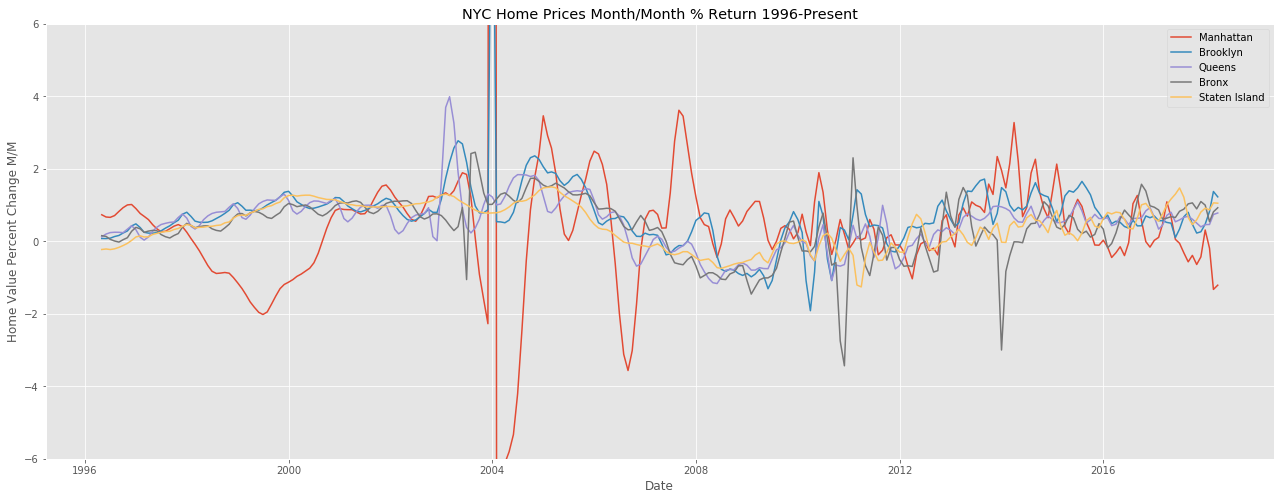

In [20]:
plt.subplots(figsize=(22,8))

plt.plot(manhattan.index, manhattan.percent)
plt.plot(brooklyn.index, brooklyn.percent)
plt.plot(queens.index, queens.percent)
plt.plot(bronx.index, bronx.percent)
plt.plot(staten.index, staten.percent)

plt.legend(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])
plt.ylabel('Home Value Percent Change M/M')
plt.xlabel('Date')
plt.title('NYC Home Prices Month/Month % Return 1996-Present')
plt.ylim(-6,6)
plt.show()

### Recommendation on Zipcodes to model:
Based on visualizations Manhattan offers the best "absolute return" compared to the other boroughs. However, Manhattan appears to have more volatility to the downside and upside - but over the long term it appears Manhattan's returns have been superior since 1996. Based on the month over month percentage return it isn't super obvious which borough would be the best to investigate.

One interesting thing to note is how well Manhattan performed during the 2008-2012 recessionary period vs the other boroughs

# Step 4: ARIMA Modeling

In [21]:
# ARIMA = AutoRegressive Integrated Moving Averages
#used to fit time series data to better understand and forecast future points in the time series
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

## Zip code variables for modeling

In [22]:
zip_10011 = states_dict['NY']['New York'][10011]

In [23]:
zip_10128 = states_dict['NY']['New York'][10128]

In [24]:
zip_10021 = states_dict['NY']['New York'][10021]

In [25]:
zip_10014 = states_dict['NY']['New York'][10014]

In [26]:
zip_11106 = states_dict['NY']['New York'][11106]

In [27]:
zip_11231 = states_dict['NY']['New York'][11231]

In [28]:
#list of the zipcodes to use for modeling
manhattan_zip_list = [zip_10011, zip_10128, zip_10021, zip_10014, zip_11106, zip_11231]

Number of AR (Auto-Regressive) terms (p):
p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of Differences (d):
d is the Integrated component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last n days is small.

Number of MA (Moving Average) terms (q):
q is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

In [29]:
#define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

In [30]:
#generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

In [31]:
#generate all different combinations of season p, d, and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## Modeling zipcode 10011

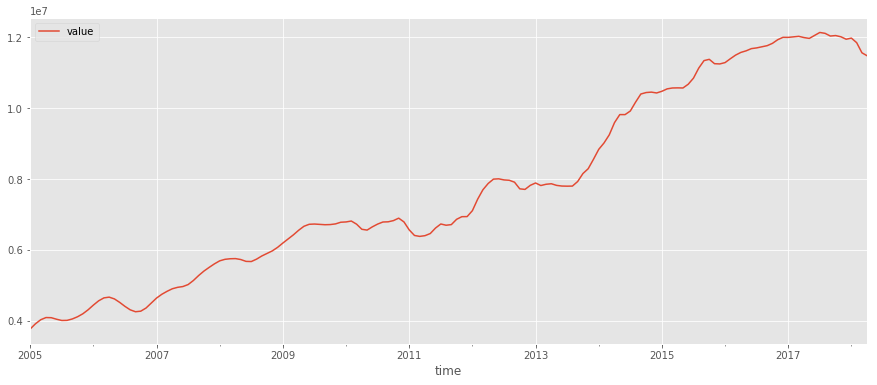

In [32]:
zip_10011.plot(figsize=(15,6))

In [33]:
zip_10011.head()

,value
time,
2005-01-01,3762100.0
2005-02-01,3908800.0
2005-03-01,4023200.0
2005-04-01,4084800.0
2005-05-01,4080800.0


AIC (Akaike Information Criterion) as Regularization Measure
AIC value, provided by ARIMA models fitted using statsmodels library.
AIC is an estimator of the relative quality of statistical models for a given data set. 
Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus AIC provides a means for model selection

A model that fits the data very well using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

Perform the following tasks:
1. initialize an empty list to store results
2. iterate through all the parameters of pdq with parameters in seasonal pdq (nested loop) to create a grid
3. run SARIMAX from statsmodels for each iteration. Set enforce_stationarity and enforce_invertibility to False.
4. Get the results in each iteration with model.fit() and store the AIC values.
5. find the lowest AIC and select parameters for fruther analysis

In [34]:
#run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
#try assigning global variables within these functions
def AIC(zipcode):
    ans = []
    global output
    global mod
    for comb in pdq:
        for combs in pdqs:
            try: 
                mod = sm.tsa.statespace.SARIMAX(zipcode,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue

In [35]:
AIC(zip_10011)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5516.213230359234
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5020.665621768527
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4441.534634054622
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =88678977.92189553
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4375.4639298486845
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4348.220662613565
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4084.240158853673
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4018.7951256078272
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5369.127150718818
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =69818438.20030549
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4590.105076400513
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4213.185862839616
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4993.252285433017
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4927.801754452321
ARIMA (0, 0, 1) x 

#the output of our code suggests ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3416.751998164864 yields the lowest AIC value. 

## Fitting an ARIMA Time Series Model
Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth

Start by plugging the optimal parameter values into a new SARIMAX model

In [36]:
def ARIMA(zipcode, p, d, q, P, D, Q, s):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zipcode,
                                            order=(p, d, q),
                                            seasonal_order=(P, D, Q, s),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    
    print(output.summary().tables[1])
    
    #use plot_diagnostics with results calculated above
    output.plot_diagnostics(figsize=(15, 18))
    plt.show()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5217      0.116      4.512      0.000       0.295       0.748
ma.L1          0.3755      0.061      6.120      0.000       0.255       0.496
ar.S.L12      -0.5190      0.135     -3.843      0.000      -0.784      -0.254
ma.S.L12      -0.0283      0.099     -0.287      0.774      -0.222       0.165
sigma2      9.793e+09   2.13e-12    4.6e+21      0.000    9.79e+09    9.79e+09


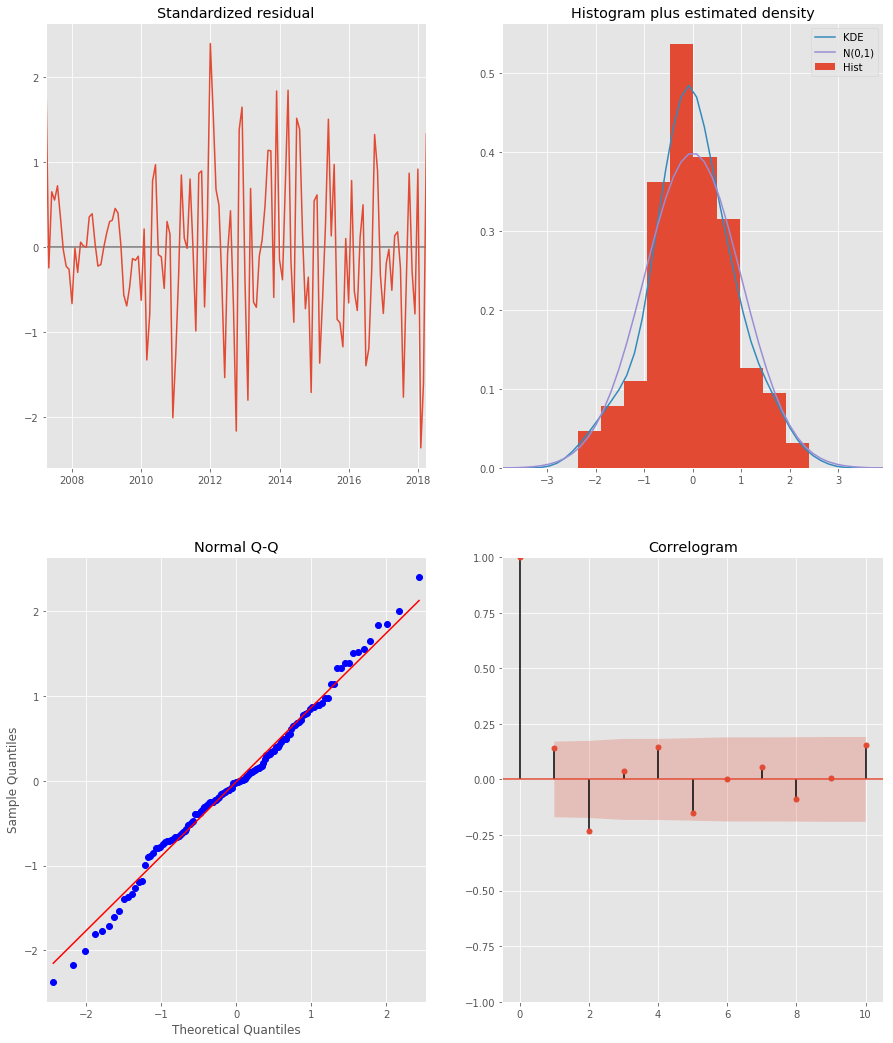

In [37]:
ARIMA(zip_10011, 1, 1, 1, 1, 1, 1, 12)

Purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. 

1. In the top right plot, the red KDE line follows somewhat closely with the N(0,1) line. This is a good indication that the residuals are normally distributed
2. QQ-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Strong indication the residuals are normally distributed.
3. Residuals over time (top left plot) dont display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation plot on the bottom right which shows that the time series residuals have low correlation with lagged versions of itself

## Validating the model

In [38]:
def forecasting(zipcode, pred_date, start_date):
    
    #make these global variables so you can access them later
    global pred
    global pred_conf
    
    #get predictions starting from specified date and calculate confident intervals 
    pred = output.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_conf = pred.conf_int()

    #plot real vs predicted values along with confidence interval 
    rcParams['figure.figsize'] = 15, 6

    #plot observed values
    ax = zipcode[start_date:].plot(label='observed')

    #plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

    #plot the range for confidence intervals 
    ax.fill_between(pred_conf.index, 
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

    #set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Home Values')
    plt.legend()

    plt.show()

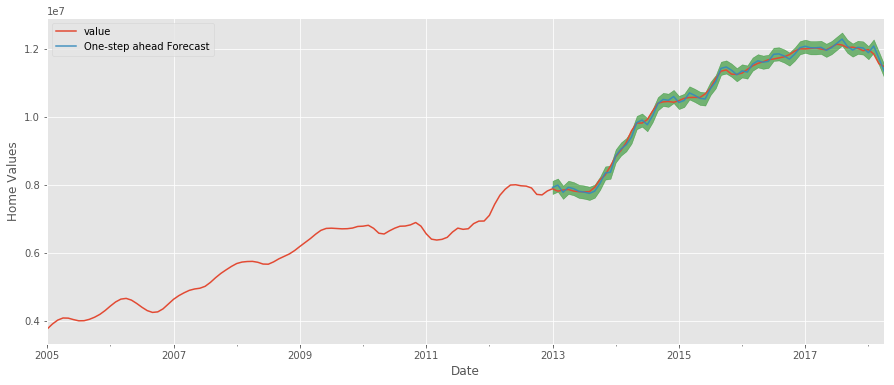

In [39]:
forecasting(zip_10011, '2013-01-01', '2005-01-01')

In [40]:
zip_10011['2013-01-01':].value

time
2013-01-01     7886000.0
2013-02-01     7814000.0
2013-03-01     7849900.0
2013-04-01     7864300.0
2013-05-01     7818000.0
2013-06-01     7799300.0
2013-07-01     7796000.0
2013-08-01     7798300.0
2013-09-01     7927500.0
2013-10-01     8152300.0
2013-11-01     8289100.0
2013-12-01     8554800.0
2014-01-01     8835500.0
2014-02-01     9015500.0
2014-03-01     9245400.0
2014-04-01     9591500.0
2014-05-01     9817900.0
2014-06-01     9817300.0
2014-07-01     9919200.0
2014-08-01    10169600.0
2014-09-01    10399000.0
2014-10-01    10440400.0
2014-11-01    10452500.0
2014-12-01    10428700.0
2015-01-01    10476500.0
2015-02-01    10544400.0
2015-03-01    10569300.0
2015-04-01    10572500.0
2015-05-01    10569500.0
2015-06-01    10674900.0
                 ...    
2015-11-01    11255300.0
2015-12-01    11248600.0
2016-01-01    11286600.0
2016-02-01    11395300.0
2016-03-01    11498100.0
2016-04-01    11574100.0
2016-05-01    11618900.0
2016-06-01    11681200.0
2016-07-01    117016

In [41]:
def mse(zipcode, pred_date):
    
    #make global variables
    global zipcode_forecasted
    global zipcode_truth
    
    #Get the real and predicted values
    zipcode_forecasted = pred.predicted_mean
    zipcode_truth = zip_10011[pred_date:].value

    #compute the mean square error
    mse = ((zipcode_forecasted - zipcode_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [42]:
mse(zip_10011, '2013-01-01')

The Mean Squared Error of our forecasts is 8887271469.16


## Dynamic Forecasting

In [43]:
def dynamic_forecasting(zipcode, pred_date, start_date):
    
    #make global variables so you can access them outside of the function
    global pred_dynamic
    global pred_dynamic_conf
    
    #get predictions starting from specified date and calculate confident intervals
    pred_dynamic = output.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()

    #plot the dynmaic forecast with conf intervals 
    ax = zipcode[start_date:].plot(label='observed', figsize=(20,15))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                   pred_dynamic_conf.iloc[:, 0],
                   pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(pred_date), zipcode_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Home Values')

    plt.legend()
    plt.show()

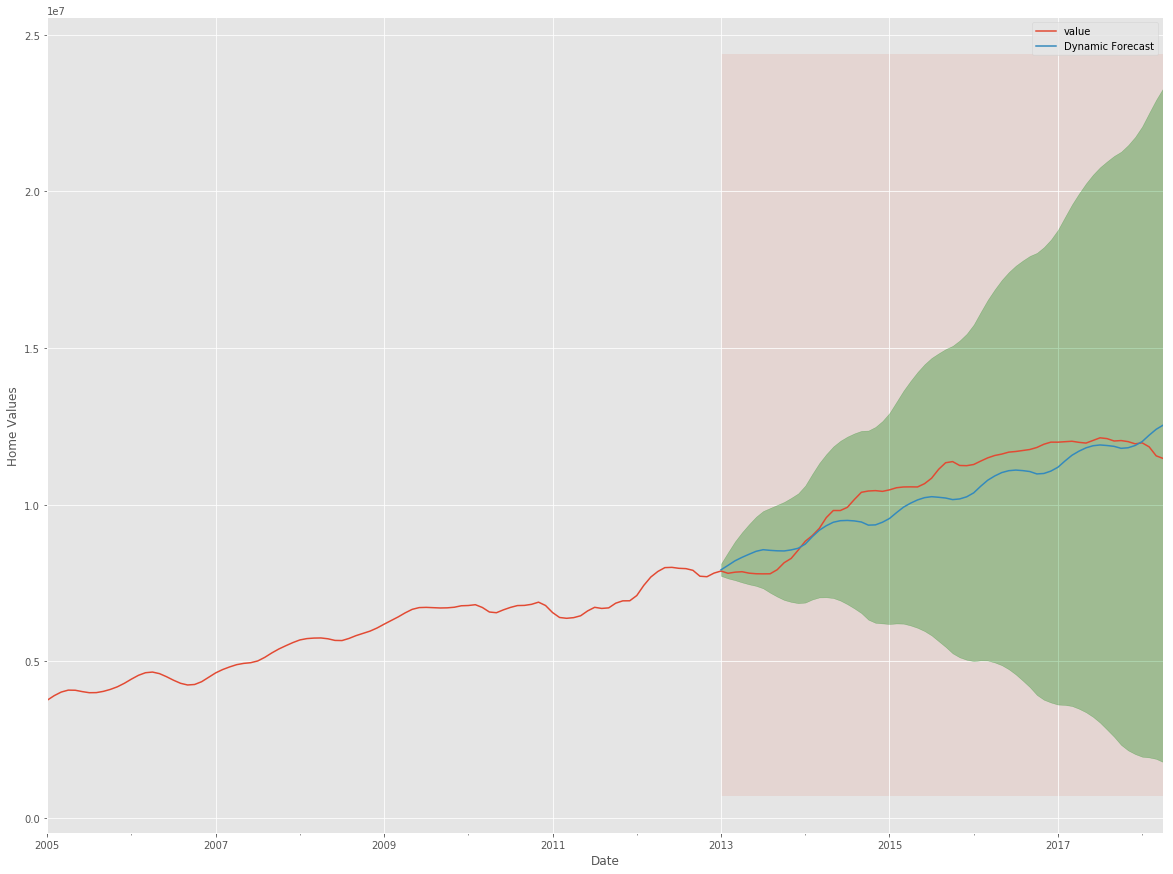

In [44]:
dynamic_forecasting(zip_10011, '2013-01-01', '2005-01-01')

In [45]:
def dynamic_mse(zipcode, pred_date):

    zipcode_forecasted = pred_dynamic.predicted_mean
    zipcode_truth = zipcode[pred_date:].value

    #compute mean square error
    mse = ((zipcode_forecasted - zipcode_truth) ** 2).mean()
    print('The mean squared error of our forecast is {}'.format(round(mse,2)))

In [46]:
dynamic_mse(zip_10011, '2013-01-01')

The mean squared error of our forecast is 424257504997.1


### Producing and Visualizing Forecasts 
get_forecast() attribute of our TS object can compute forecasted values for a specified number of steps ahead

In [47]:
def forecasting_future(zipcode, steps):

    #make global variables
    global prediction
    global pred_conf
    
    #get a forecast steps ahead in the future
    #5 years in the future = 60 steps
    prediction = output.get_forecast(steps=steps)

    #get confidence intervals of forecasts
    pred_conf = prediction.conf_int()

    #plot future predictions with confidence intervals

    ax = zipcode.plot(label='observed', figsize=(20,15))
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_conf.index,
                   pred_conf.iloc[:, 0],
                   pred_conf.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Home Prices')

    plt.legend()
    plt.show()

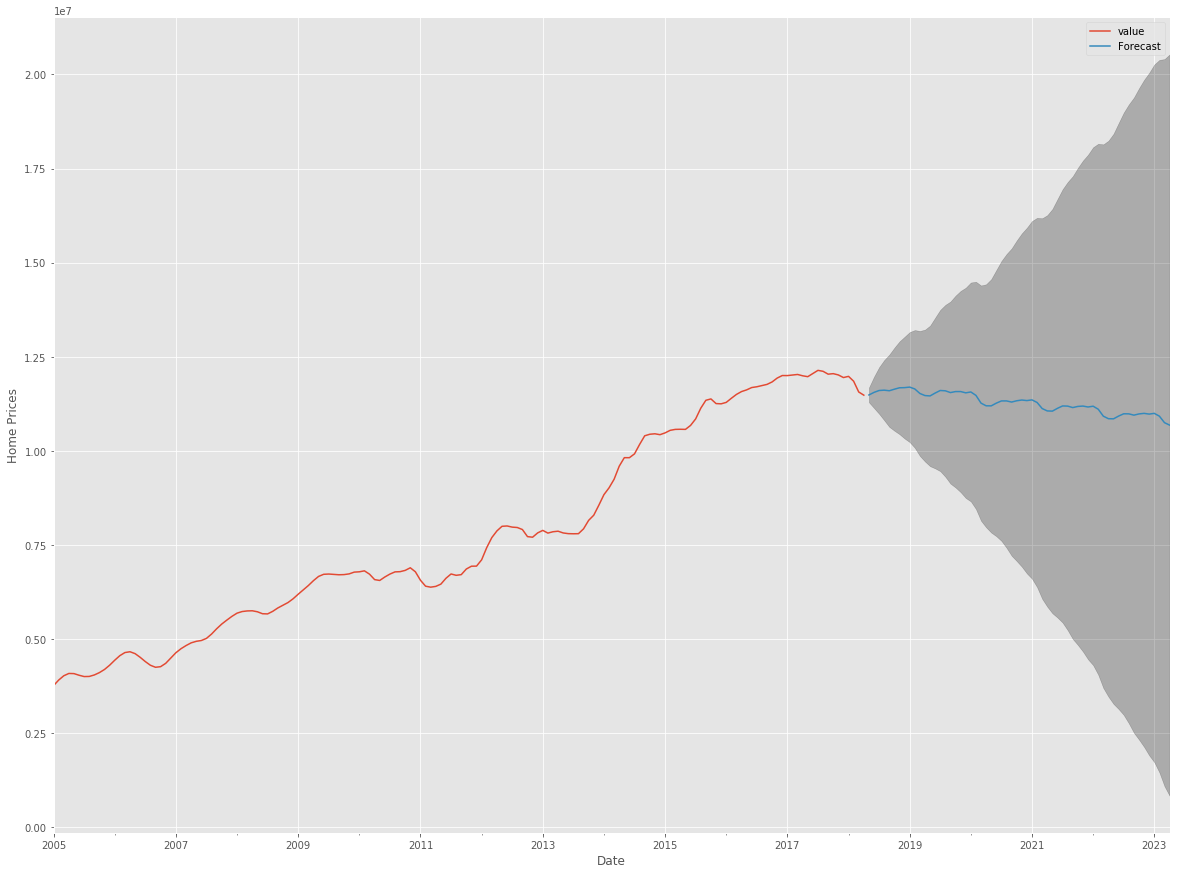

In [48]:
forecasting_future(zip_10011, 60)

## Modeling zipcode 10128

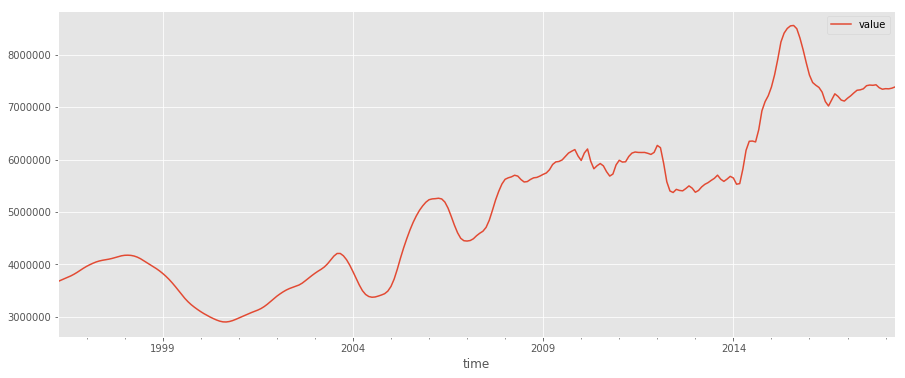

In [49]:
zip_10128.plot(figsize=(15,6))

In [50]:
zip_10128.head()

,value
time,
1996-04-01,3676700.0
1996-05-01,3704200.0
1996-06-01,3729600.0
1996-07-01,3754600.0
1996-08-01,3781800.0


In [51]:
AIC(zip_10128)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =8926.149975255816
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =8362.729813924165
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =7532.451653477156
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =7173.691432509328
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =7555.652997137375
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =7522.089737902208
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =7205.201455050367
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7173.945816913381
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =8702.205909235417
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =8889.322444060726
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =7787.172710928304
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7176.383618297023
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =8308.44462505953
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =8886.231545635828
ARIMA (0, 0, 1) x (1,

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6453      0.056     11.506      0.000       0.535       0.755
ma.L1          0.4078      0.027     14.989      0.000       0.354       0.461
ar.S.L12      -0.4998      0.058     -8.679      0.000      -0.613      -0.387
ma.S.L12      -0.0563      0.039     -1.434      0.152      -0.133       0.021
sigma2       6.46e+09   1.83e-12   3.53e+21      0.000    6.46e+09    6.46e+09


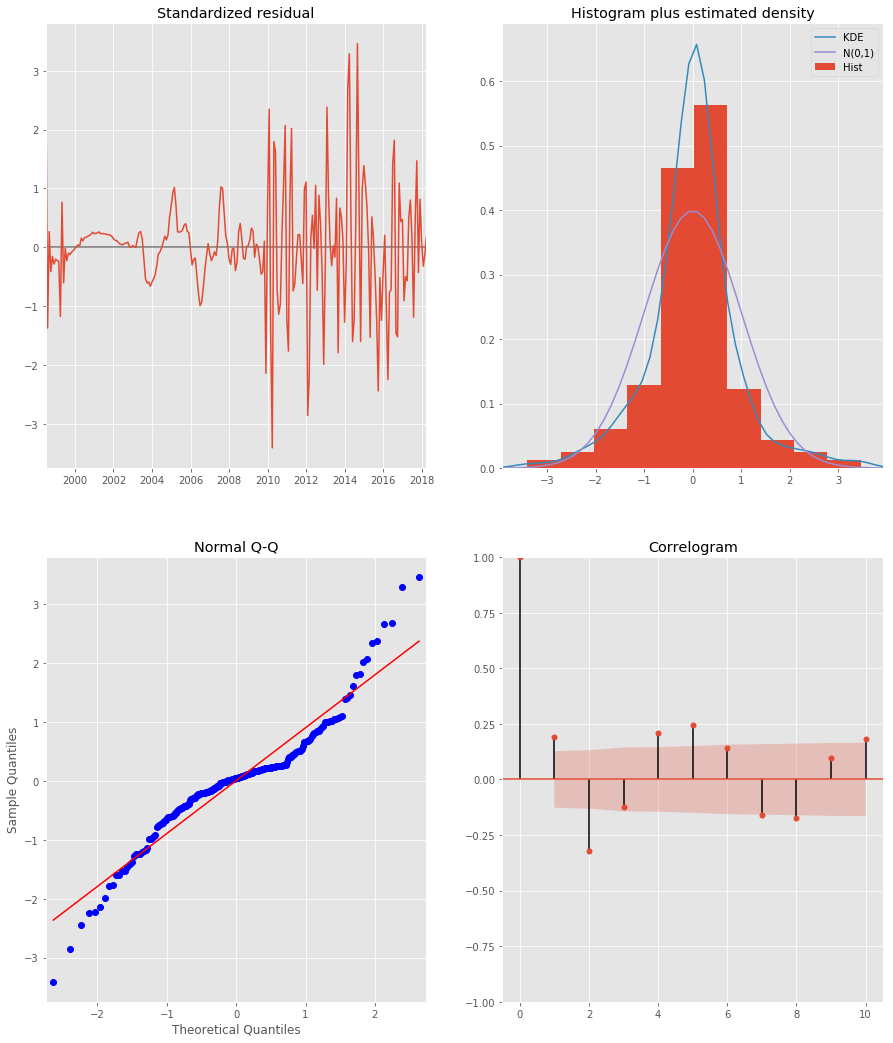

In [52]:
ARIMA(zip_10128, 1, 1, 1, 1, 1, 1, 12)

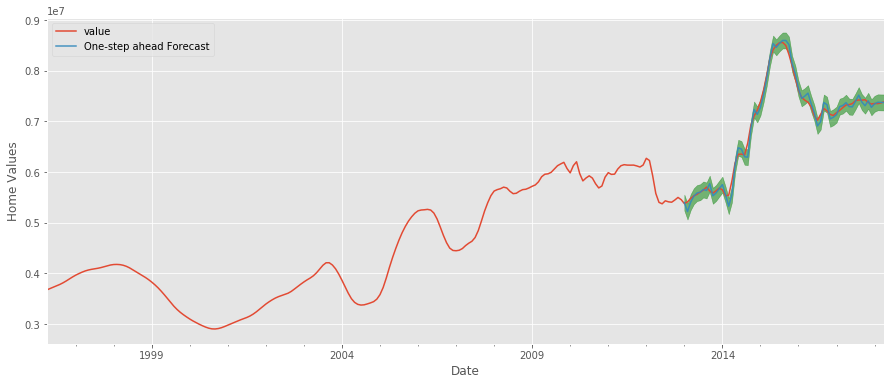

In [53]:
forecasting(zip_10128, '2013-01-01', '1996-04-01')

In [54]:
mse(zip_10128, '2013-01-01')

The Mean Squared Error of our forecasts is 13889792763409.88


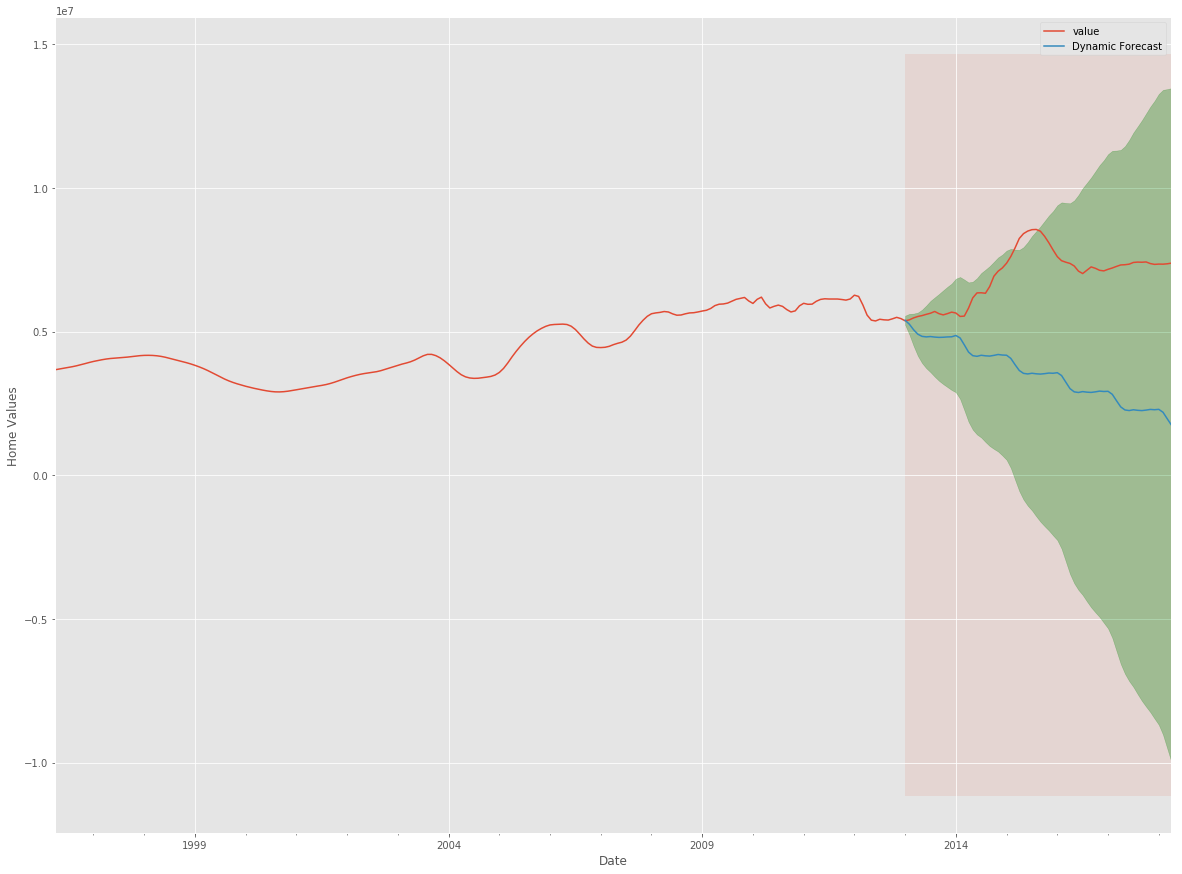

In [55]:
dynamic_forecasting(zip_10128, '2013-01-01', '1996-04-01')

In [56]:
dynamic_mse(zip_10128, '2013-01-01')

The mean squared error of our forecast is 14445784219522.74


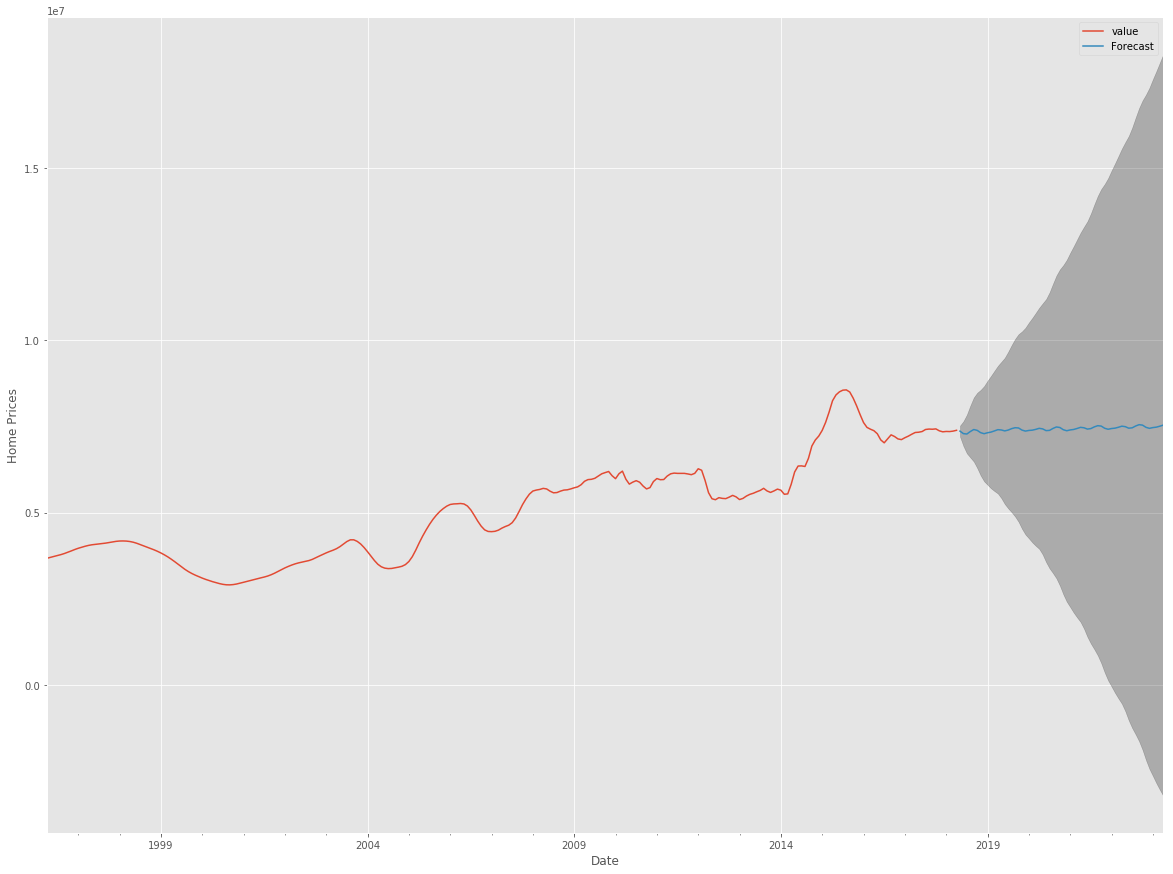

In [57]:
forecasting_future(zip_10128, 60)

## Modeling zipcode 10021

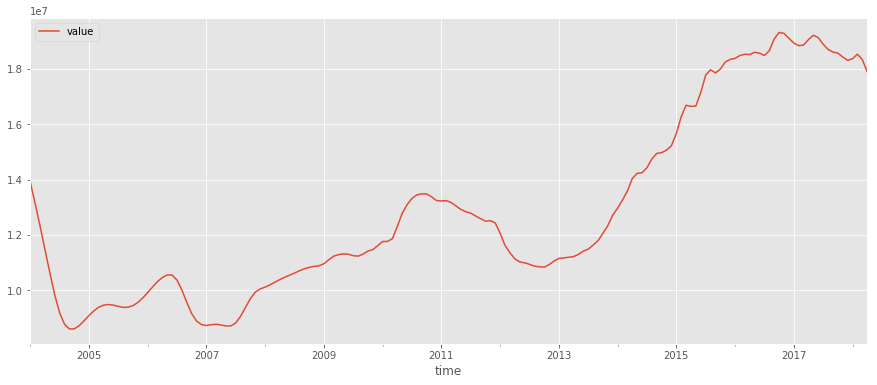

In [58]:
zip_10021.plot(figsize=(15,6))

In [59]:
zip_10021.head()

,value
time,
2004-01-01,13922800.0
2004-02-01,13140500.0
2004-03-01,12333800.0
2004-04-01,11490700.0
2004-05-01,10641200.0


In [60]:
AIC(zip_10021)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6096.685366868576
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5578.689835761027
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4998.793560546435
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =97292.42155455658
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5018.846166161995
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4973.772789490242
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4637.369917467438
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4606.600028323388
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5939.963284652288
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =17335.128968676545
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5200.946348736039
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =5422157.5063307015
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6121.804588497991
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =5952.278891730807
ARIMA (0, 0, 1) x 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7121      0.059     12.032      0.000       0.596       0.828
ma.L1          0.2567      0.024     10.698      0.000       0.210       0.304
ar.S.L12      -0.4769      0.067     -7.123      0.000      -0.608      -0.346
ma.S.L12      -0.0124      0.053     -0.236      0.813      -0.116       0.091
sigma2      2.135e+10    6.8e-13   3.14e+22      0.000    2.14e+10    2.14e+10


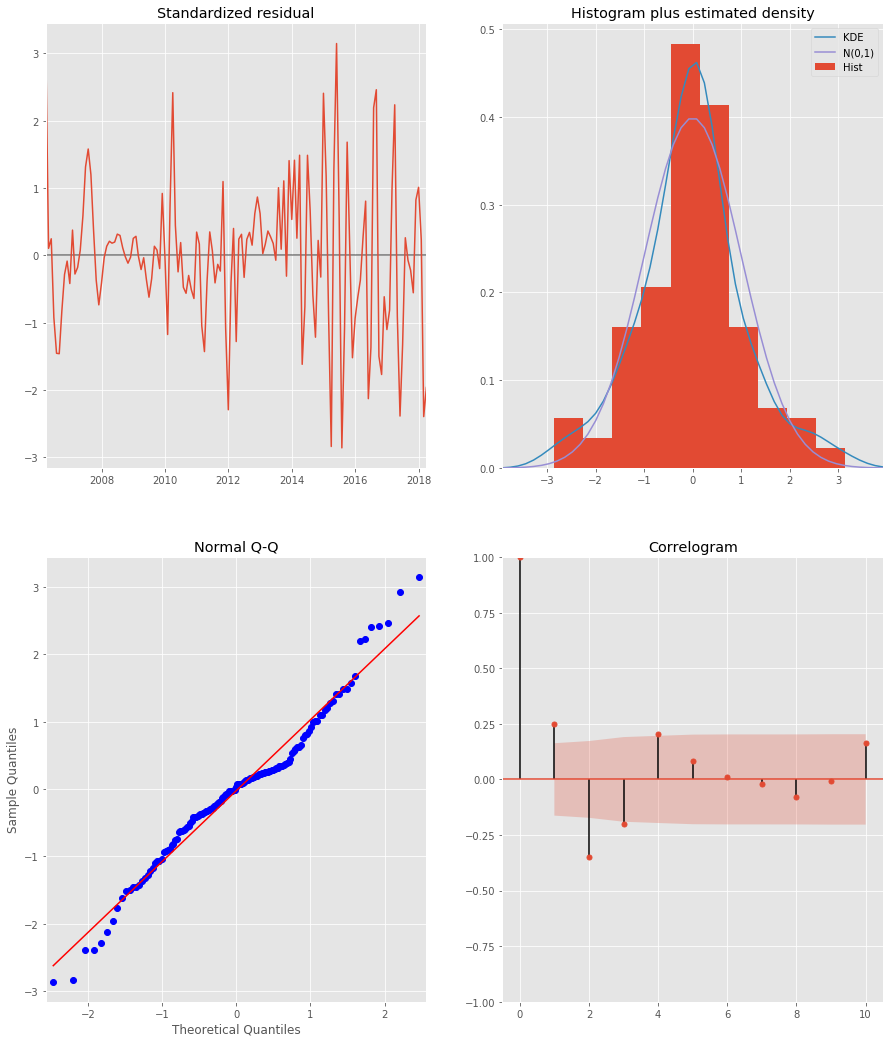

In [61]:
ARIMA(zip_10021, 1, 1, 1, 1, 1, 1, 12)

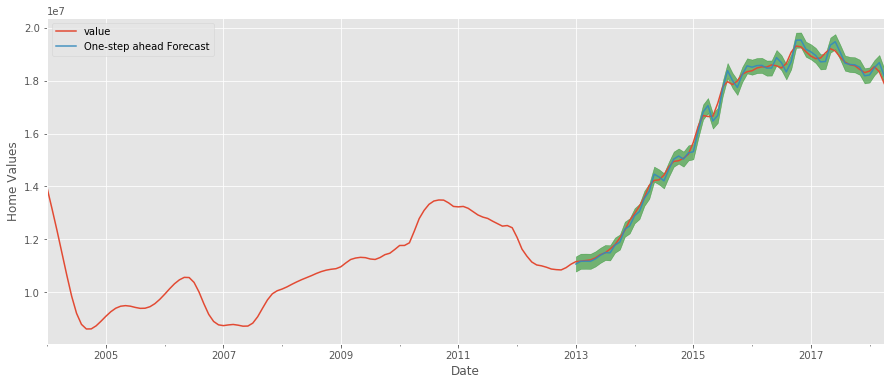

In [62]:
forecasting(zip_10021, '2013-01-01', '2004-01-01')

In [63]:
mse(zip_10021, '2013-01-01')

The Mean Squared Error of our forecasts is 34886350393044.91


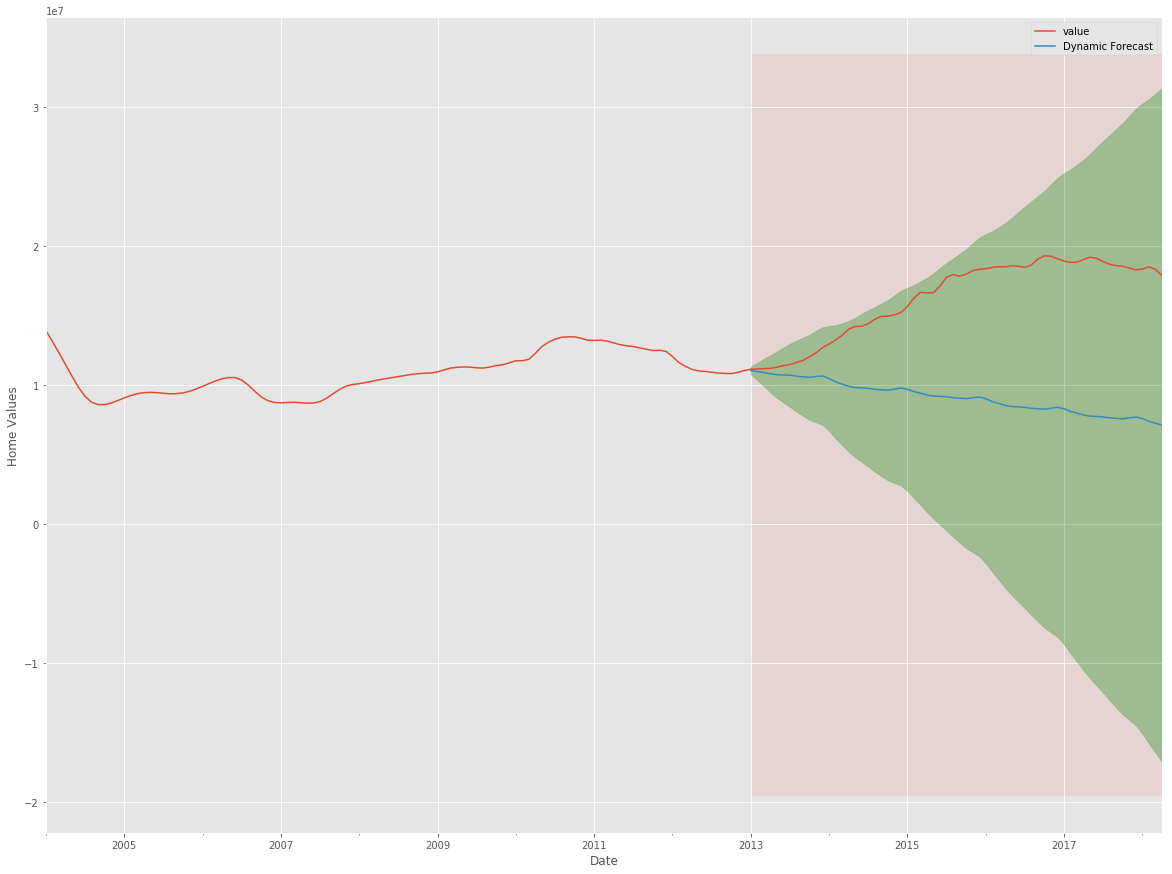

In [64]:
dynamic_forecasting(zip_10021, '2013-01-01', '2004-01-01')

In [65]:
dynamic_mse(zip_10021, '2013-01-01')

The mean squared error of our forecast is 66141579210373.0


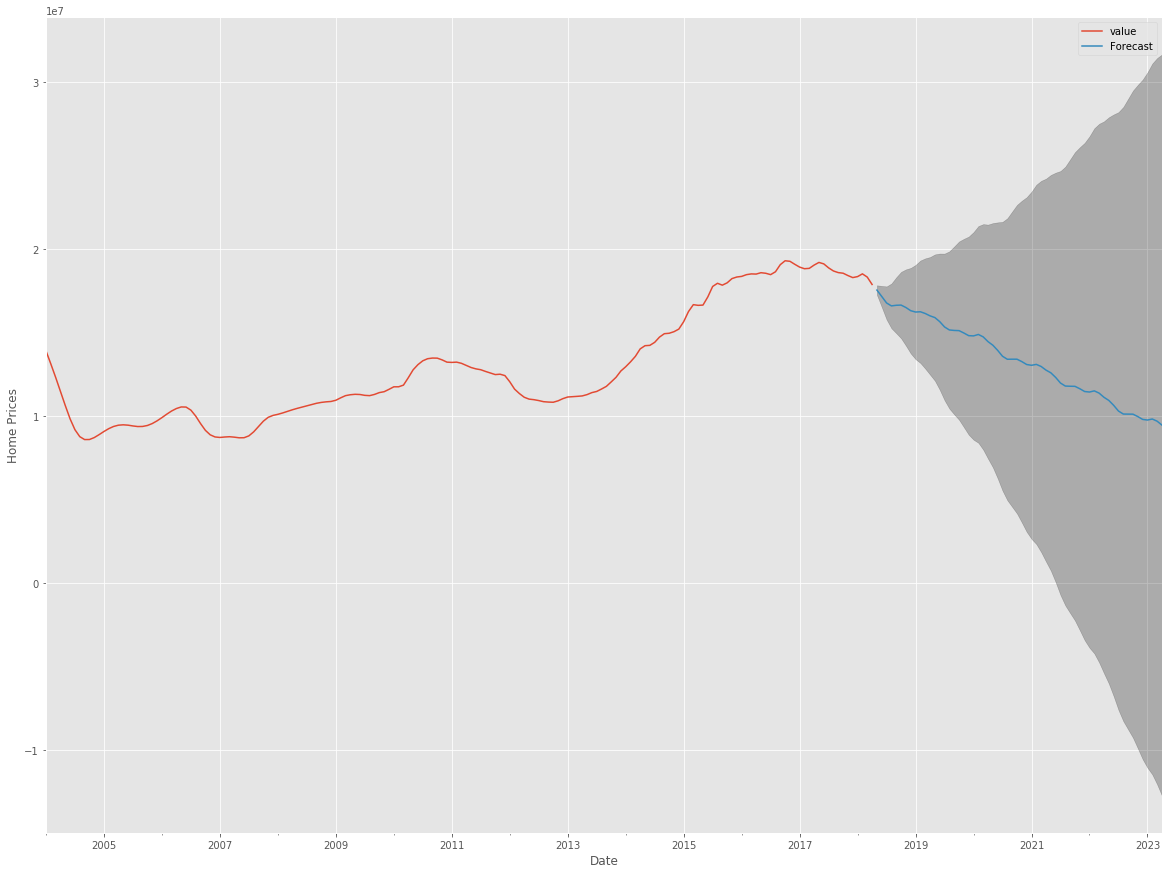

In [66]:
forecasting_future(zip_10021, 60)

## Modeling zipcode 10014

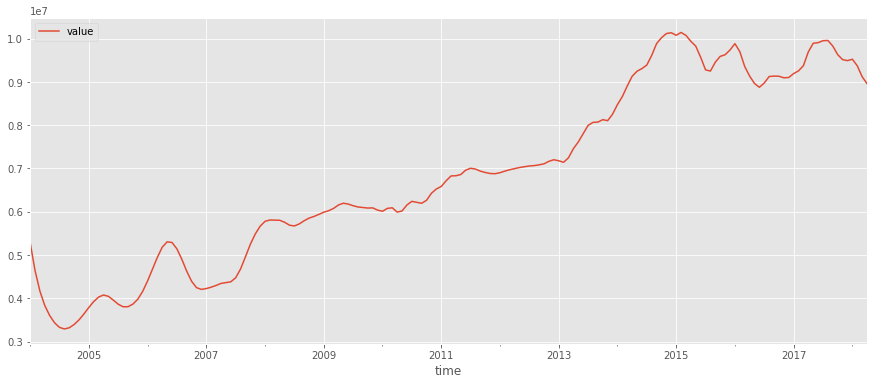

In [67]:
zip_10014.plot(figsize=(15,6))

In [68]:
zip_10014.head()

,value
time,
2004-01-01,5299500.0
2004-02-01,4648100.0
2004-03-01,4168100.0
2004-04-01,3833300.0
2004-05-01,3601700.0


In [69]:
AIC(zip_10014)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5885.040367110924
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =5384.903956788337
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4779.8470365130925
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =75930599.77105868
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4776.9491005273885
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4743.143855242124
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4455.142788124974
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4399.852915877581
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5729.817641955195
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =5715.0685106985675
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4945.5863067810715
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4285.770424985256
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =5353.243936270208
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =5714.261480075919
ARIMA (0, 0, 1) 

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7274      0.065     11.248      0.000       0.601       0.854
ma.L1          0.3104      0.039      7.946      0.000       0.234       0.387
ar.S.L12      -0.4041      0.107     -3.783      0.000      -0.613      -0.195
ma.S.L12      -0.0304      0.075     -0.407      0.684      -0.177       0.116
sigma2      9.511e+09   1.15e-12   8.28e+21      0.000    9.51e+09    9.51e+09


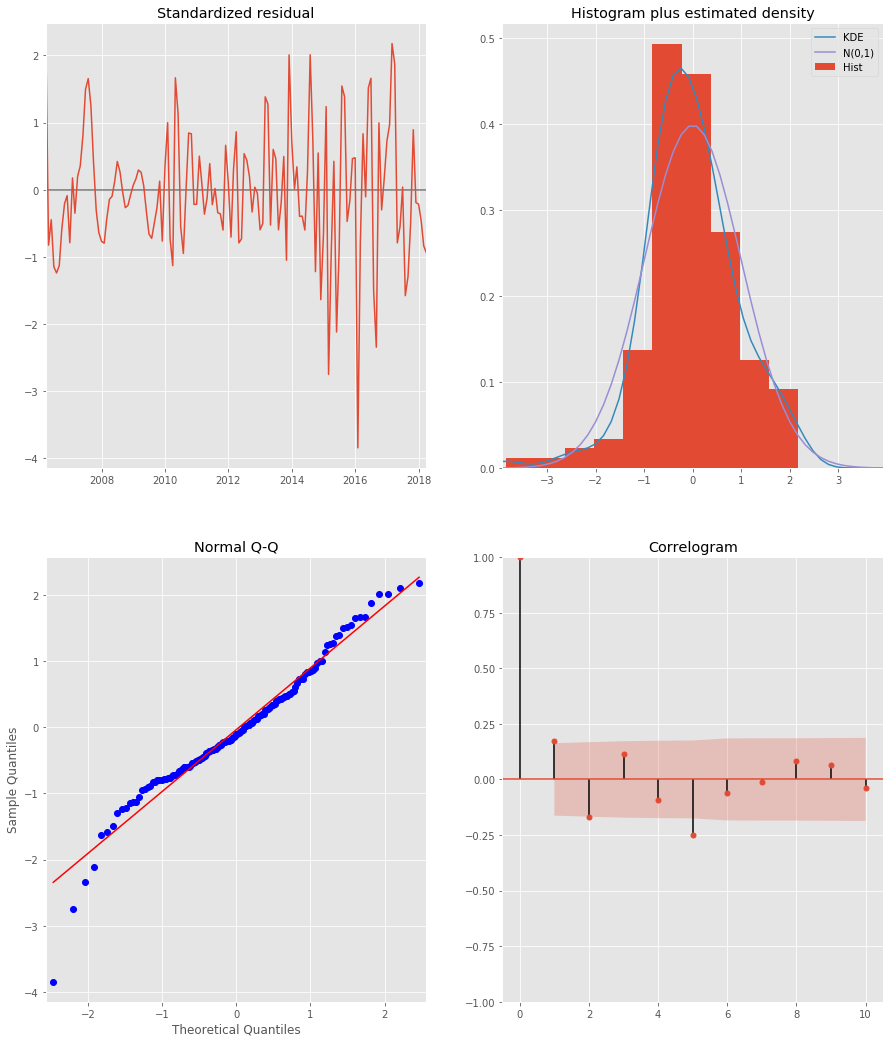

In [70]:
ARIMA(zip_10014, 1, 1, 1, 1, 1, 1, 12)

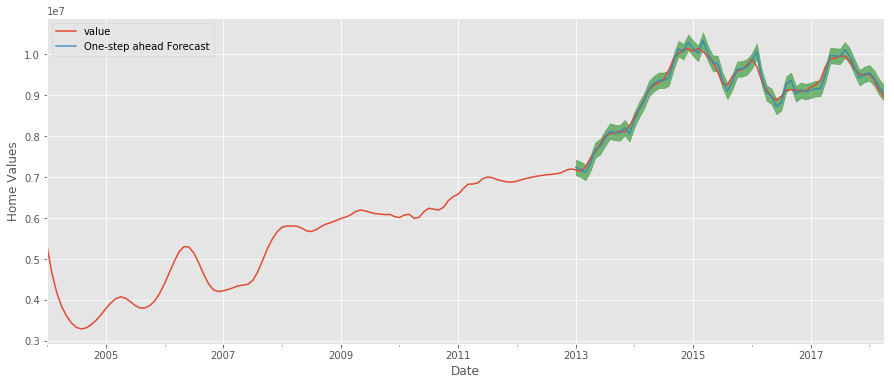

In [71]:
forecasting(zip_10014, '2013-01-01', '2004-01-01')

In [72]:
mse(zip_10014, '2013-01-01')

The Mean Squared Error of our forecasts is 3023738102333.76


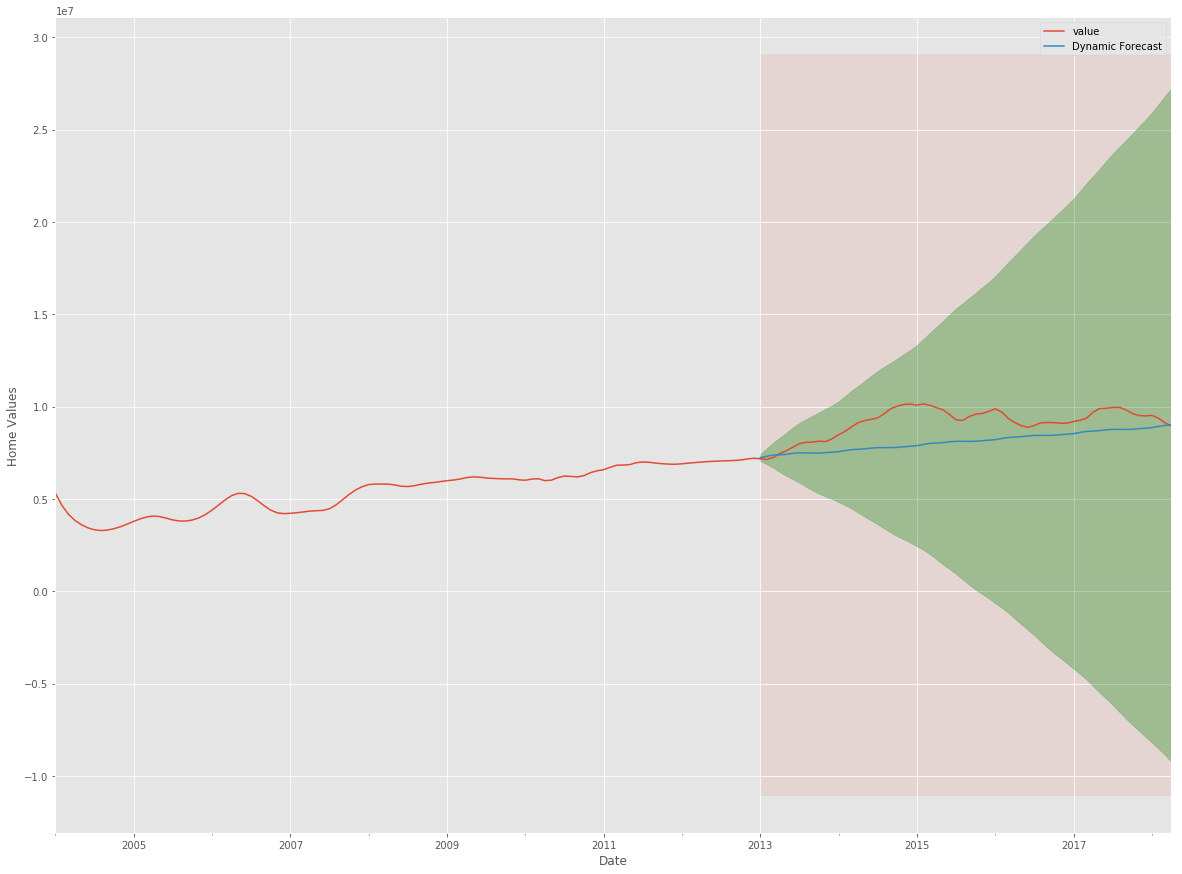

In [73]:
dynamic_forecasting(zip_10014, '2013-01-01', '2004-01-01')

In [74]:
dynamic_mse(zip_10014, '2013-01-01')

The mean squared error of our forecast is 1465227330859.56


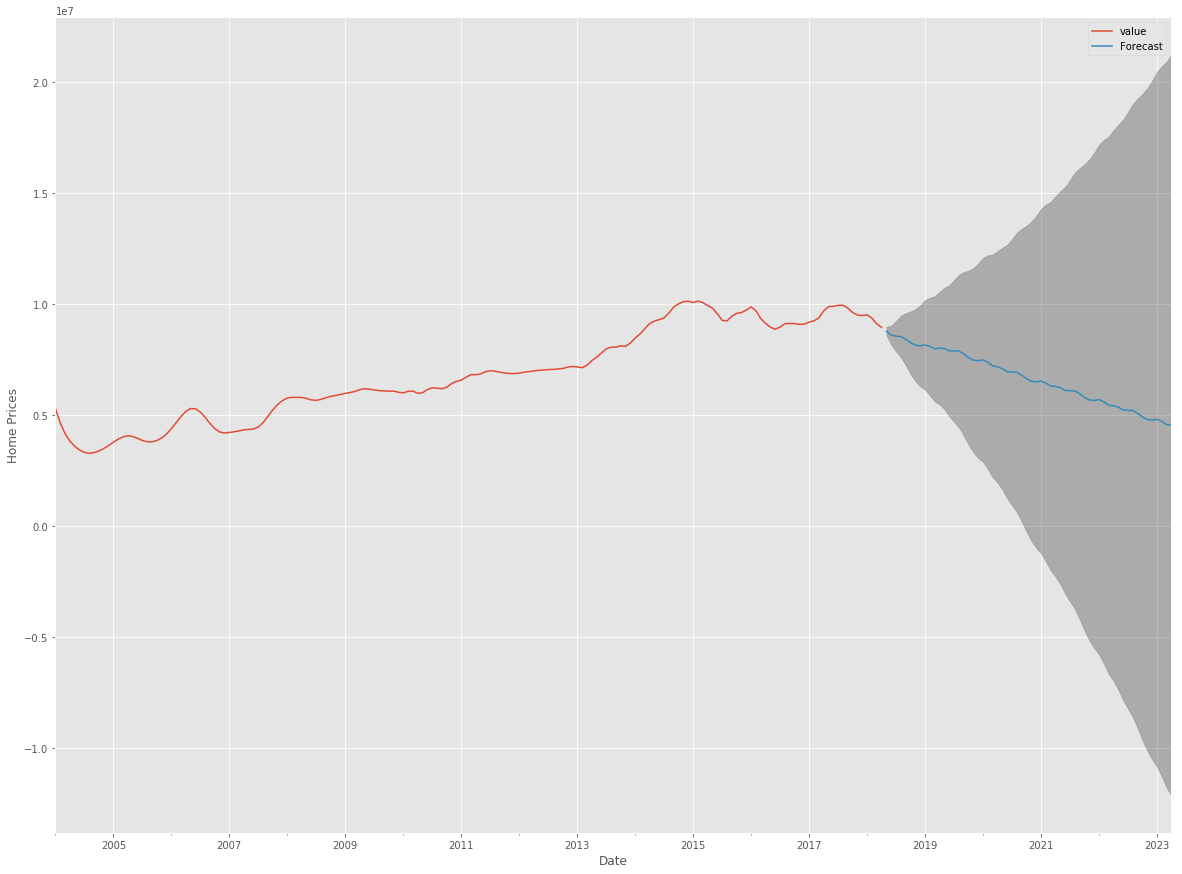

In [75]:
forecasting_future(zip_10014, 60)

## Modeling zipcode 11106

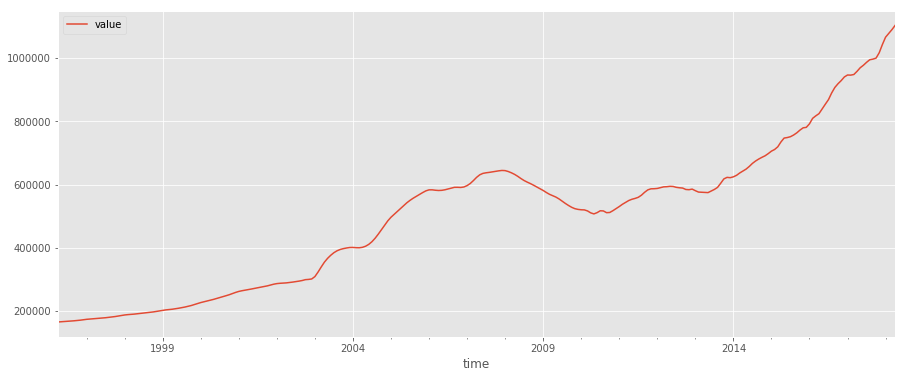

In [76]:
zip_11106.plot(figsize=(15,6))

In [77]:
zip_11106.head()

,value
time,
1996-04-01,164600.0
1996-05-01,165300.0
1996-06-01,165900.0
1996-07-01,166700.0
1996-08-01,167400.0


In [78]:
AIC(zip_11106)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7735.003099660269
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7230.786456440528
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6306.618493206286
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =6019.268413183905
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =6190.89785744674
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =6139.446903700978
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5875.081468181119
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =7712.7925984603435
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7514.863436816242
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =7129.626703095753
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =6345.905160191373
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =5792.794780133781
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =7167.102601599912
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =7112.363551560255
ARIMA (0, 0, 1) x (1

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7239      0.051     14.320      0.000       0.625       0.823
ma.L1          0.4121      0.029     13.976      0.000       0.354       0.470
ar.S.L12      -0.4897      0.071     -6.854      0.000      -0.630      -0.350
ma.S.L12      -0.0448      0.066     -0.679      0.497      -0.174       0.085
sigma2      1.195e+07   2.18e-09   5.48e+15      0.000    1.19e+07    1.19e+07


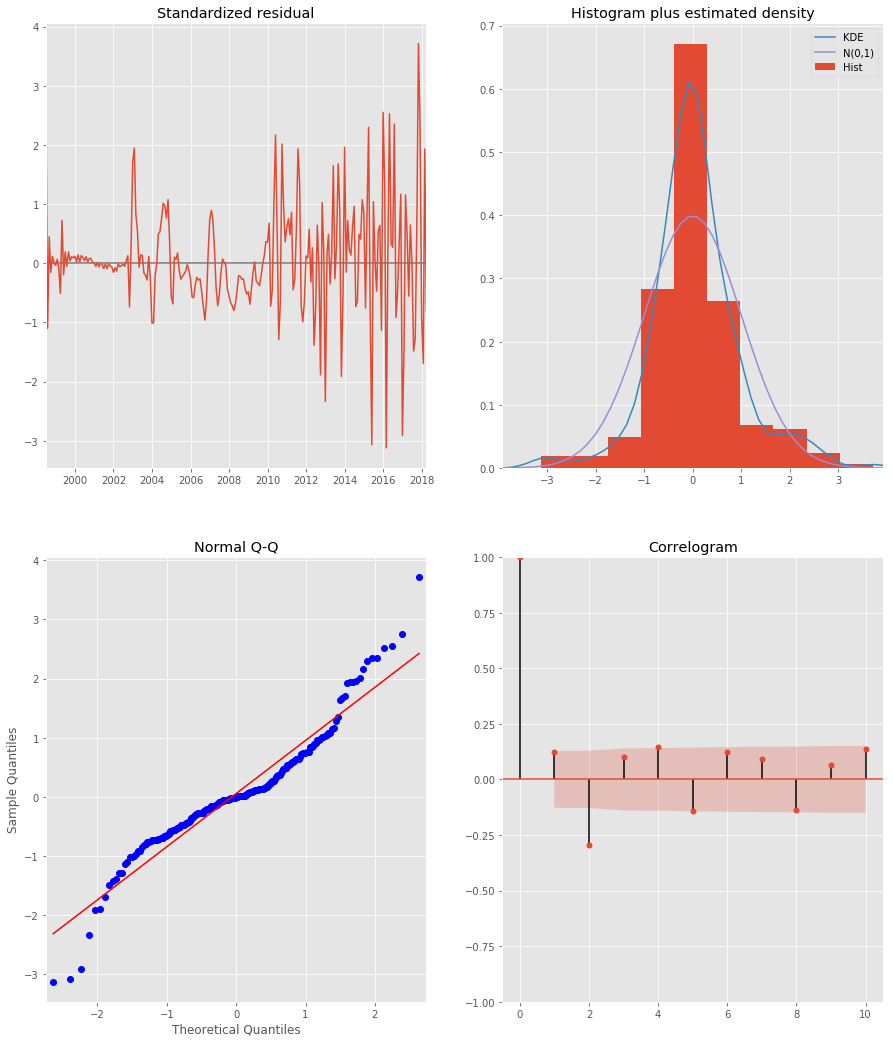

In [79]:
ARIMA(zip_11106, 1, 1, 1, 1, 1, 1, 12)

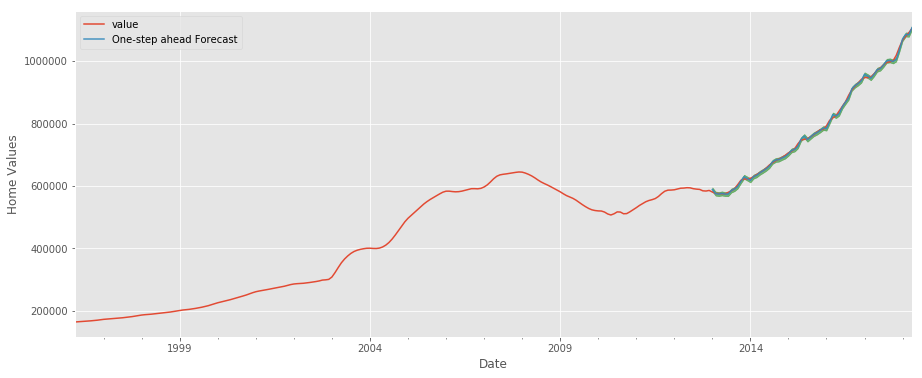

In [80]:
forecasting(zip_11106, '2013-01-01', '1996-04-01')

In [81]:
mse(zip_11106, '2013-01-01')

The Mean Squared Error of our forecasts is 97183808314612.06


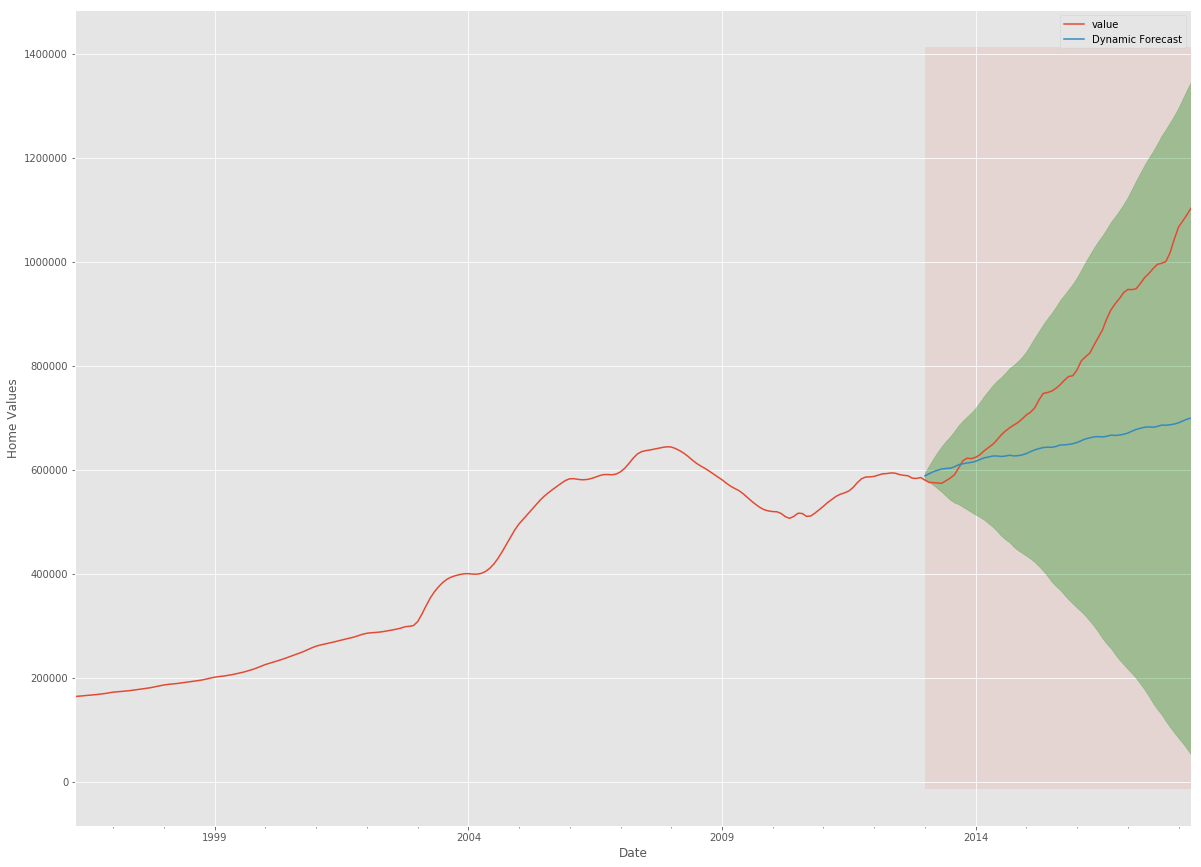

In [82]:
dynamic_forecasting(zip_11106, '2013-01-01', '1996-04-01')

In [83]:
dynamic_mse(zip_11106, '2013-01-01')

The mean squared error of our forecast is 37198662496.16


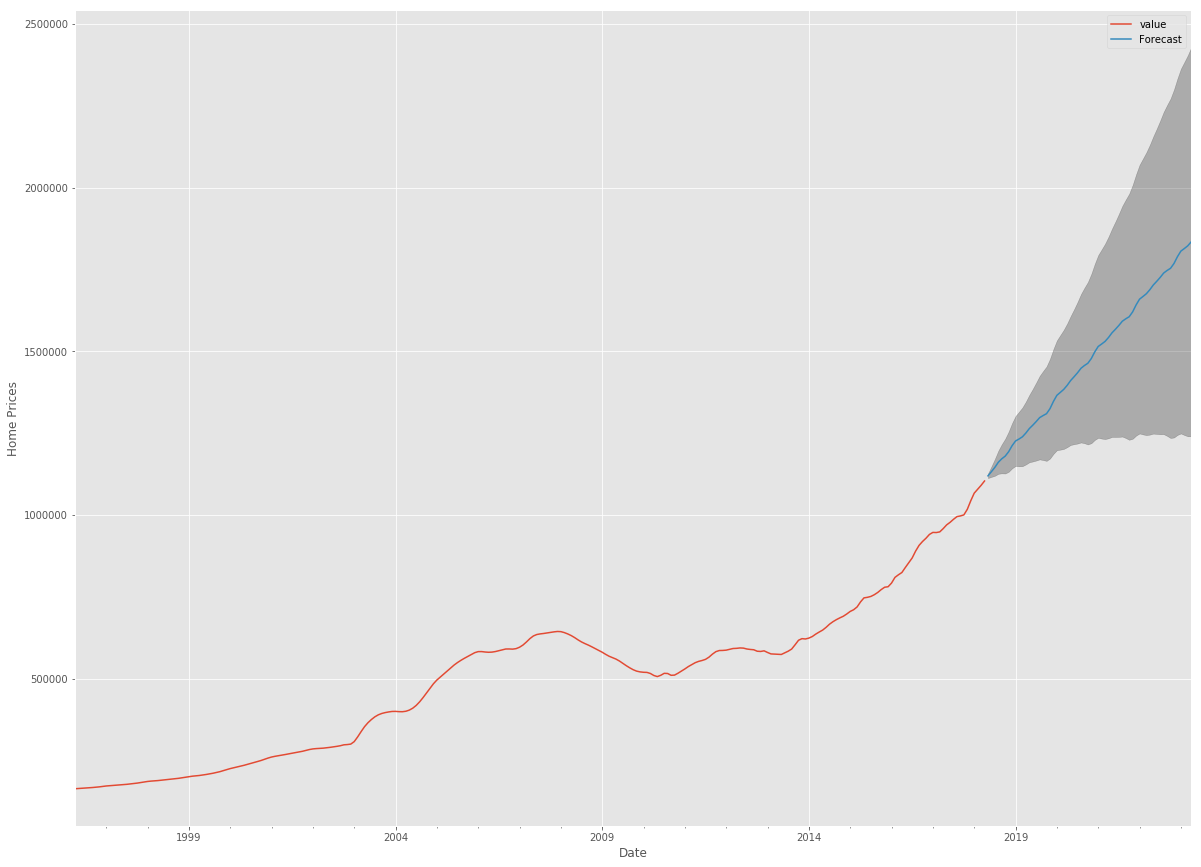

In [84]:
forecasting_future(zip_11106, 60)

## Modeling zipcode 11231

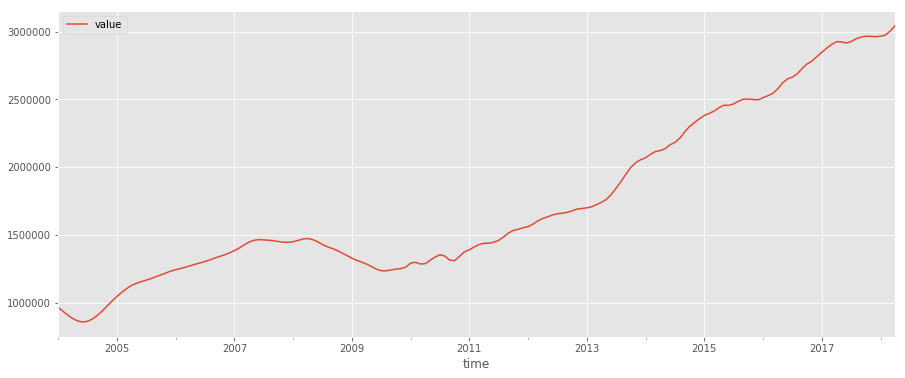

In [85]:
zip_11231.plot(figsize=(15,6))

In [86]:
zip_11231.head()

,value
time,
2004-01-01,969500.0
2004-02-01,940900.0
2004-03-01,912300.0
2004-04-01,887300.0
2004-05-01,869900.0


In [87]:
AIC(zip_11231)

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5423.9708093629815
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4953.349702945598
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4343.500124754707
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =3964.179365194841
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4224.726704777125
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4167.708544112808
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =3911.0932416918577
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =3886.920566948631
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5271.202299206425
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4873.687916089701
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4438.507909420481
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =3870.265360578961
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4921.7144850657605
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4862.131977724339
ARIMA (0, 0, 1) x

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7302      0.071     10.278      0.000       0.591       0.869
ma.L1          0.2318      0.033      7.053      0.000       0.167       0.296
ar.S.L12      -0.5738      0.086     -6.685      0.000      -0.742      -0.406
ma.S.L12      -0.0071      0.054     -0.131      0.895      -0.113       0.099
sigma2      1.344e+08   9.15e-11   1.47e+18      0.000    1.34e+08    1.34e+08


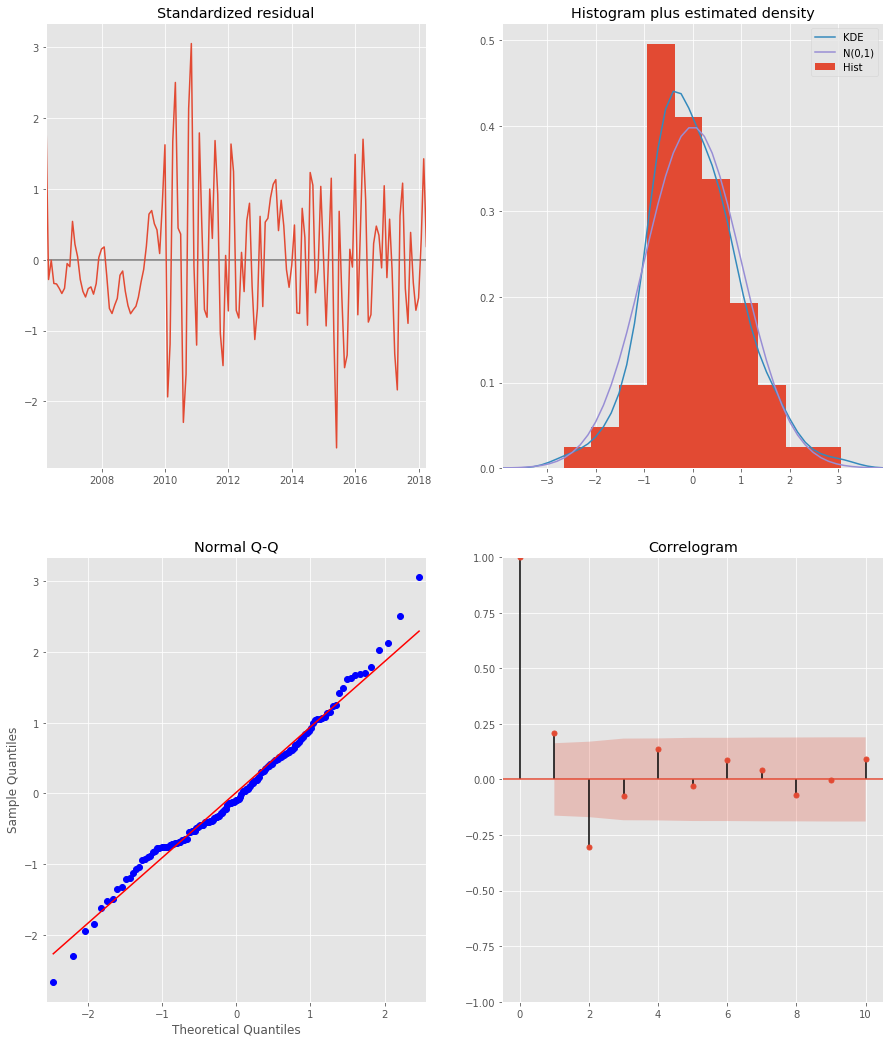

In [88]:
ARIMA(zip_11231, 1, 1, 1, 1, 1, 1, 12)

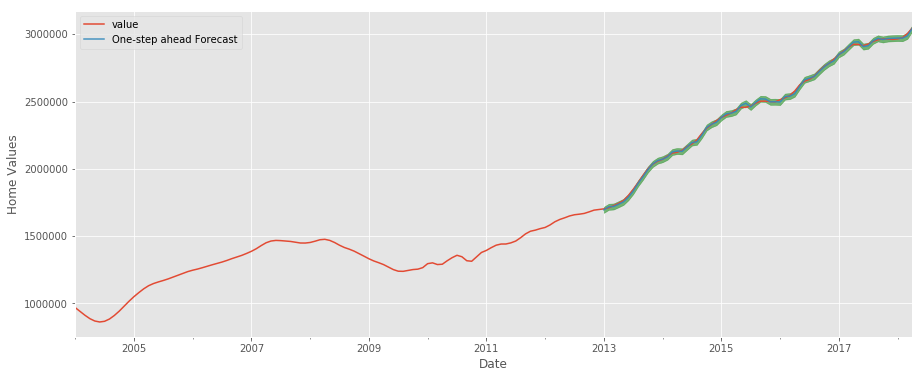

In [89]:
forecasting(zip_11231, '2013-01-01', '2004-01-01')

In [90]:
mse(zip_11231, '2013-01-01')

The Mean Squared Error of our forecasts is 66865194785944.61


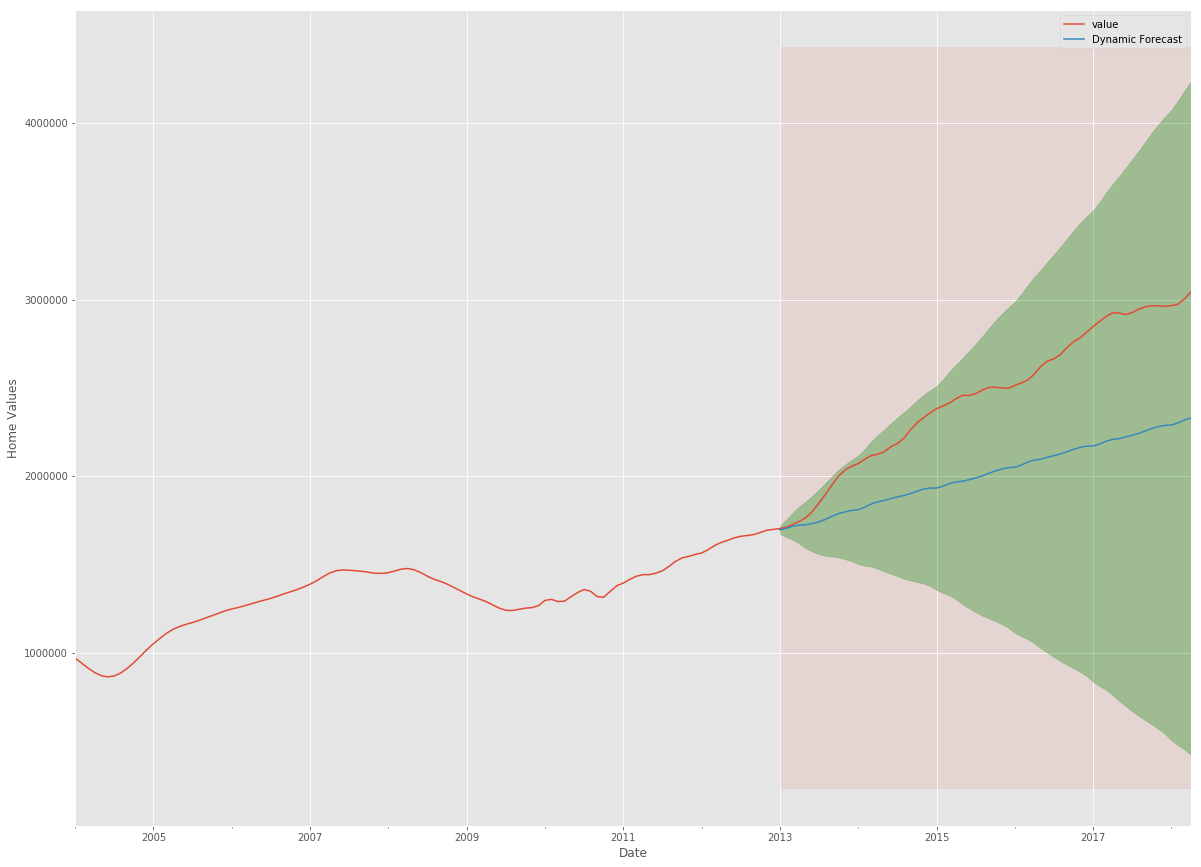

In [91]:
dynamic_forecasting(zip_11231, '2013-01-01', '2004-01-01')

In [92]:
dynamic_mse(zip_11231, '2013-01-01')

The mean squared error of our forecast is 241678221066.38


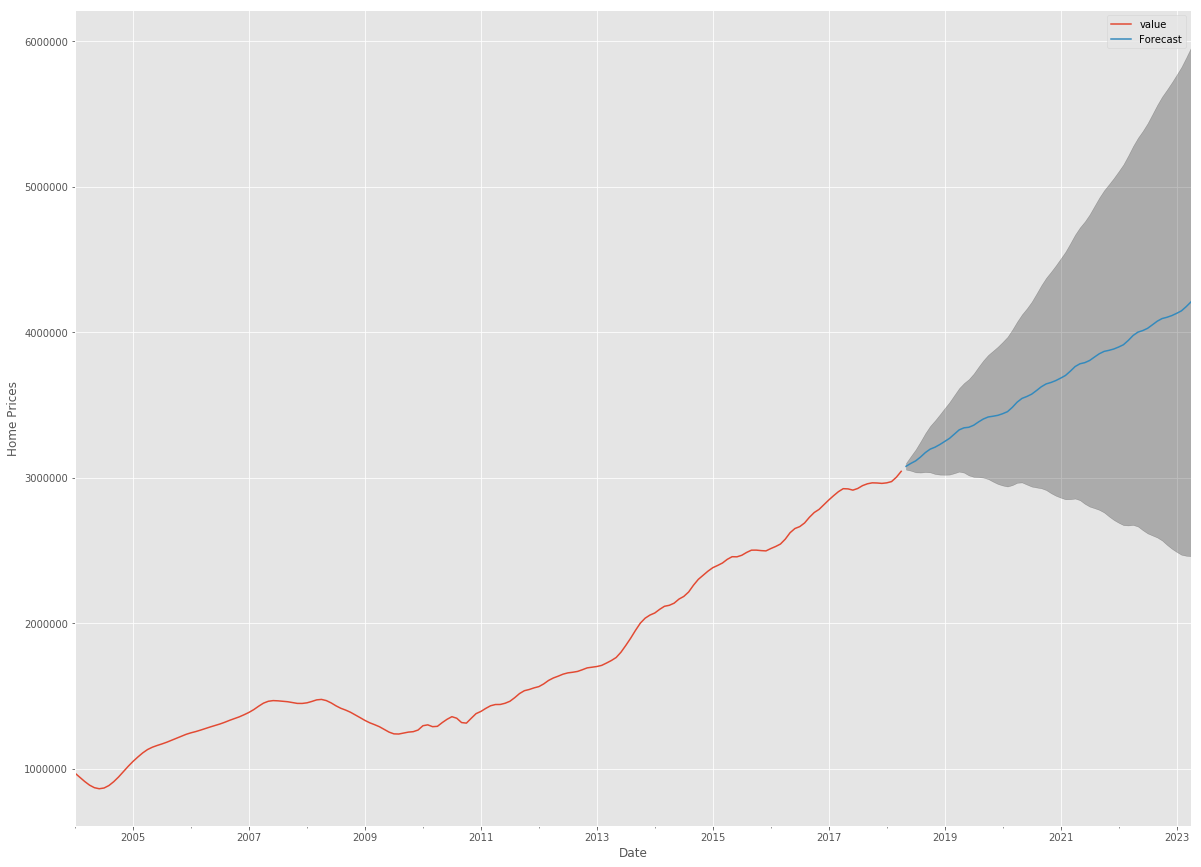

In [93]:
forecasting_future(zip_11231, 60)

# Step 5: Interpreting Results

Most of these models are very flawed for multiple reasons:
1. p-value of moving average seasonal coefficient (ma.s) is very large and statistically insignificant.
2. the red KDE line isnt that close to the N(0,1) line. This is an indication that the residuals are not normally distributed
3. one step ahead forecast looks OK, not great
4. dynamic forecasting is very far off and the confidence interval is very spread - model is basically guessing
5. The seasonal ARIMA time series model to forecast future values looks very inaccurate based on the confidence interval - model is basically guessing again.

I would try making my pdq multiples 0,1, and 2 instead of just 0,1 but my computer can't handle a second order model.

### Create an ARIMA time series model forecast with all 6 zipcodes from Manhattan group to make recommendation:

Based on the forecasting models my recommendation to investors would be:
1. Invest in 11231 and 11106 as their trajectory looks pretty good - even the lower end of the confidence intervals give you positive returns in the enxt 5 years.
2. Zipcodes 10011, and 10128 are relatively flat trajectories - confidence intervals are really wide and the mode is just guessing though
3. Zipcodes 10021 and 10014 have downward trajectories over the next 5 years, but once again this model doesn't have very accurate forecasting ability.